# Transfer Learning to Ma 2021 Benchmark
### Load data

In [ ]:
import os
os.chdir("..")
os.getcwd()

In [2]:
import pandas as pd
data_path = "notebooks/ma_2021"
mol_df = pd.read_csv(os.path.join(data_path,"molecules.csv"))
mol_df.head()

,CID,MolecularWeight,IsomericSMILES,IUPACName,name
0,179,88.11,CC(C(=O)C)O,3-hydroxybutan-2-one,acetoin
1,240,106.12,C1=CC=C(C=C1)C=O,benzaldehyde,benzaldehyde
2,261,72.11,CCCC=O,butanal,butyraldehyde
3,454,128.21,CCCCCCCC=O,octanal,octanal
4,650,86.09,CC(=O)C(=O)C,"butane-2,3-dione","2,3-butanedione"


### Make fingerprints

In [3]:
import analysis.fingerprint
mfpgen = analysis.fingerprint.make_mfpgen()
mol_df["MFP"] = mol_df["IsomericSMILES"].map(lambda smiles: analysis.fingerprint.smiles_to_embed(mfpgen,smiles))
mol_df["MFP"].head()

0    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: MFP, dtype: object

In [4]:
cid_to_embed = mol_df[["CID","MFP"]].set_index("CID").to_dict()["MFP"]
len(cid_to_embed), next(iter(cid_to_embed.items()))

(72, (179, array([0, 1, 0, ..., 0, 0, 0], dtype=uint8)))

### Aggregate different ratings

In [5]:
blends_df = pd.read_csv(os.path.join(data_path,"behavior.csv"))
blends_df

,Stimulus A,Stimulus B,Subject,Rep,IA,IAmix,IB,IBmix,IAB,PA,PB,PAB
0,179,31249,2,1,1.6,0.0,5.6,7.0,6.8,6.3,5.6,5.5
1,179,31249,3,1,5.0,5.3,4.9,5.1,6.3,6.8,3.6,4.2
2,179,31249,5,1,5.2,4.7,5.4,3.8,4.9,3.7,5.3,3.8
3,179,31249,7,1,4.1,0.0,8.0,10.0,7.0,4.0,6.0,6.0
4,179,31249,14,1,5.2,5.7,5.8,4.1,5.4,5.1,5.1,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...
6655,9855795,5281167,56,1,5.0,7.0,4.0,5.6,9.0,4.0,4.0,0.7
6656,9855795,5281167,59,1,8.7,9.6,8.5,11.0,9.0,2.0,2.9,1.8
6657,9855795,5281167,60,1,5.2,3.9,5.5,3.0,5.1,8.0,7.8,7.1
6658,9855795,5281167,62,1,5.1,2.6,3.8,0.0,5.2,8.0,9.3,9.5


In [6]:
all_blends = set()
for i, row in blends_df.iterrows():
    all_blends.add((row["Stimulus A"],row["Stimulus B"]))
print(f"Found {len(all_blends)} unique blends.")

Found 198 unique blends.


In [7]:
import numpy as np

# Stack the prediction targets
value_cols = ["IA", "IAmix", "IB", "IBmix", "IAB", "PA", "PB", "PAB"]
blends_df["Values"] = blends_df.apply(lambda row: np.stack(row[value_cols]).tolist(), axis=1)

group_df = blends_df.groupby(["Stimulus A", "Stimulus B"])

# Calculate the mean for the "Values" column along axis=0
result_df = group_df["Values"].apply(
    lambda group: np.mean(np.stack(group.to_numpy()), axis=0).tolist()
).reset_index(name="Values")

# Display the resulting DataFrame
result_df.head()

,Stimulus A,Stimulus B,Values
0,179,31249,"[5.623333333333333, 5.656666666666667, 6.30666..."
1,240,61592,"[7.280000000000001, 5.889999999999999, 4.28666..."
2,261,61592,"[6.826666666666665, 6.336666666666667, 4.93666..."
3,454,7590,"[5.993333333333331, 4.973333333333333, 6.22666..."
4,454,31260,"[5.790000000000001, 4.300000000000001, 5.55999..."


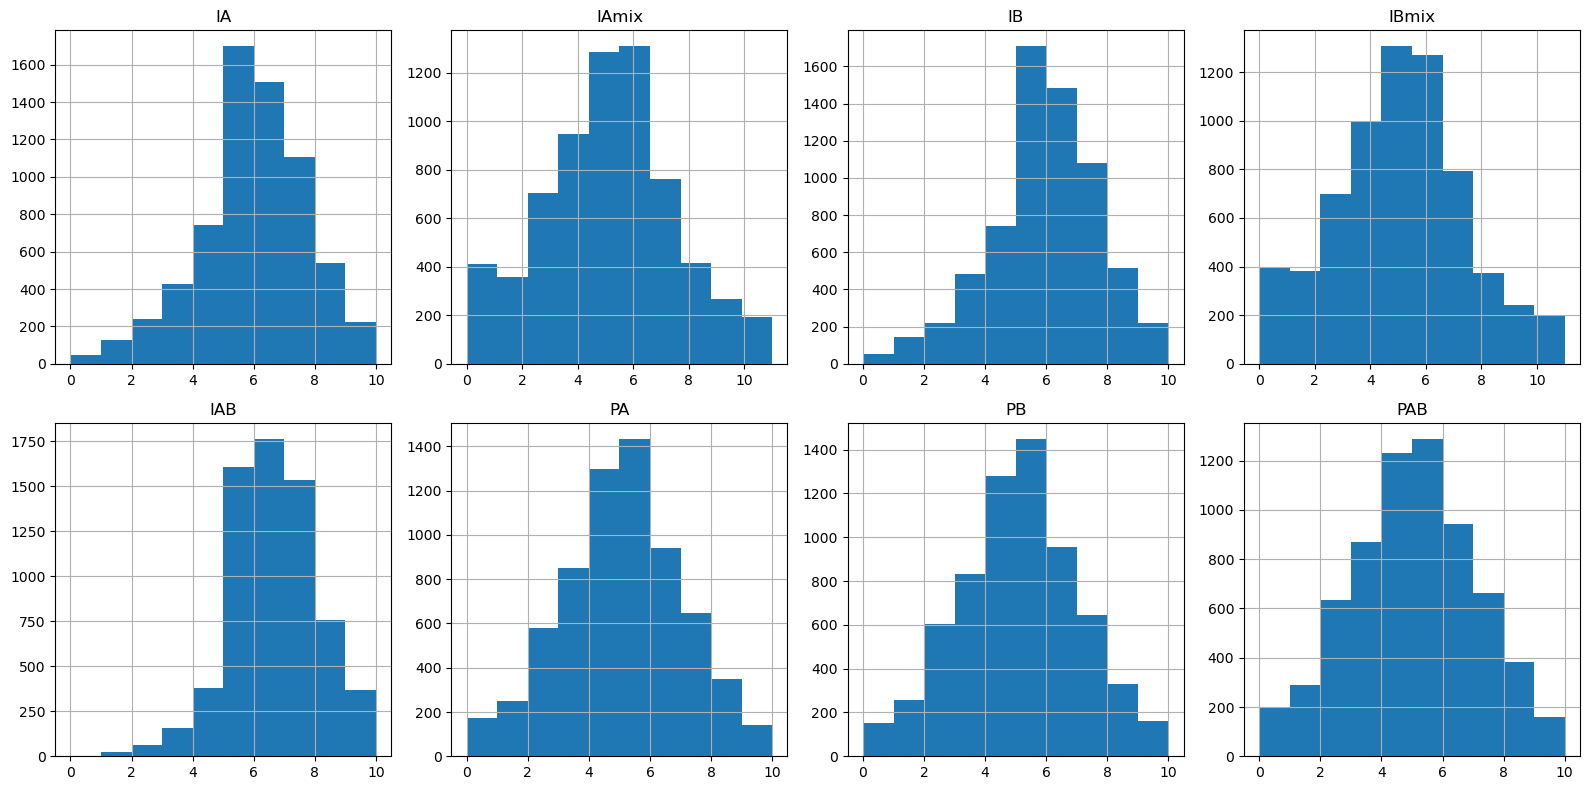

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid
for ax, k in zip(axes.flatten(), value_cols):
    blends_df[k].hist(bins=10, ax=ax)  # Plot histogram for each key
    ax.set_title(k)  # Set the title for each subplot

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### Morgan Fingerpint Model

In [9]:
import numpy as np

# Make MFP emeddings for each molecule
result_df["Embed A"] = result_df["Stimulus A"].map(cid_to_embed)
result_df["Embed B"] = result_df["Stimulus B"].map(cid_to_embed)

def combine_embeds(row):
    embeds = row[["Embed A","Embed B"]].tolist()
    return np.concatenate(embeds)

# Combine the pair embeddings through concatenation
result_df["Embed"] = result_df.apply(lambda row: combine_embeds(row), axis=1)
result_df

,Stimulus A,Stimulus B,Values,Embed A,Embed B,Embed
0,179,31249,"[5.623333333333333, 5.656666666666667, 6.30666...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,240,61592,"[7.280000000000001, 5.889999999999999, 4.28666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,261,61592,"[6.826666666666665, 6.336666666666667, 4.93666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,454,7590,"[5.993333333333331, 4.973333333333333, 6.22666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,454,31260,"[5.790000000000001, 4.300000000000001, 5.55999...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
193,9855795,7463,"[6.296666666666667, 5.696666666666666, 5.84666...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
194,9855795,7765,"[6.203333333333333, 5.500000000000001, 5.17833...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
195,9855795,8093,"[6.319999999999999, 5.5600000000000005, 6.2933...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
196,9855795,31249,"[6.0, 4.873333333333334, 5.833333333333334, 4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


  0%|          | 0/5 [00:00<?, ?it/s]

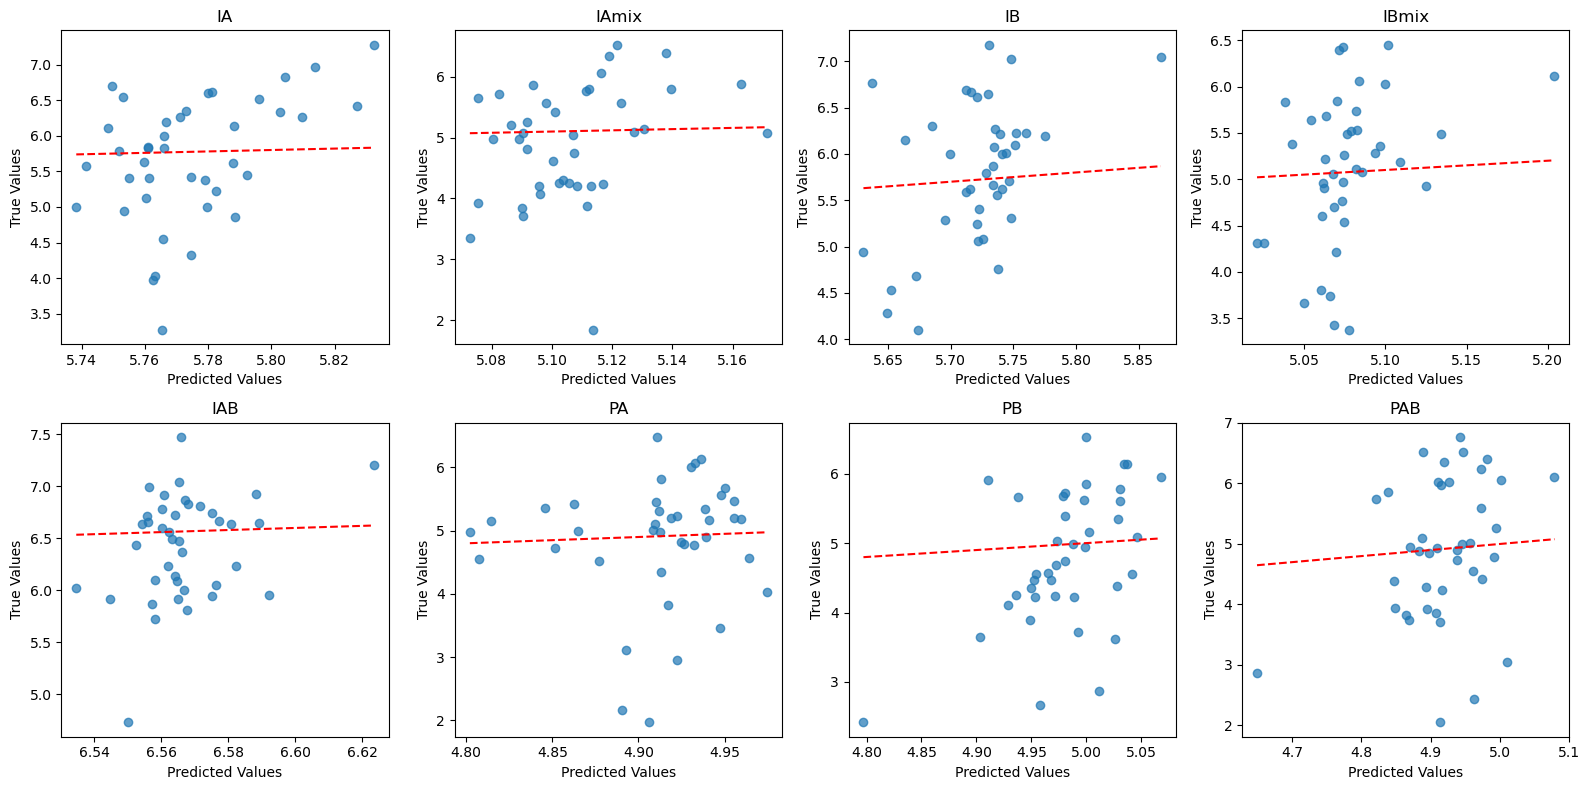

{'IA': '0.486 ± 0.30',
 'IAmix': '0.808 ± 0.37',
 'IB': '0.567 ± 0.15',
 'IBmix': '0.833 ± 0.30',
 'IAB': '0.281 ± 0.02',
 'PA': '0.764 ± 0.65',
 'PB': '0.849 ± 0.22',
 'PAB': '0.930 ± 0.42'}

In [10]:
import scipy.stats as stats
import sklearn
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import sklearn.multioutput
from tqdm.notebook import tqdm
import numpy as np

n_splits = 5

def plot_predictions(y_pred, y_test):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid
    for ax, k, i in zip(axes.flatten(), value_cols, range(len(value_cols))):
        ax.scatter(y_pred[:, i], y_test[:, i], alpha=0.7)
        ax.set_title(k)
        ax.set_xlabel("Predicted Values")
        ax.set_ylabel("True Values")
        ax.plot([min(y_pred[:, i]), max(y_pred[:, i])], [min(y_pred[:, i]), max(y_pred[:, i])], color='red', linestyle='--')  # Diagonal line

    plt.tight_layout()
    plt.show()

def train_model(df):
    # Convert "Embed" and "Values" to matrices
    X = np.vstack(df["Embed"].to_numpy())  # Convert list/array-like embeddings to a matrix
    y = np.vstack(df["Values"].to_numpy())

    # Initialize k-fold cross-validation
    kfold = sklearn.model_selection.KFold(n_splits=n_splits, shuffle=False)

    # Initialize a dictionary to store MSEs for each value
    mse_dict = {col: [] for col in value_cols}

    for fold_idx, (train_index, test_index) in enumerate(tqdm(kfold.split(X), total=n_splits)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Use SVR directly
        model = sklearn.multioutput.MultiOutputRegressor(SVR(kernel="rbf",gamma="scale",C=1e-1,epsilon=1))
        model.fit(X_train, y_train)

        # Predict the entire vector
        y_pred = model.predict(X_test)
        
        if fold_idx == 0:
            plot_predictions(y_pred, y_test)

        # Calculate and store MSE for each value (column)
        for i, col in enumerate(value_cols):
            mse = mean_squared_error(y_test[:, i], y_pred[:, i])
            mse_dict[col].append(mse)

    results_dict = dict()        
    # Report MSE for each fold and value with mean ± confidence interval
    for col, mse_list in mse_dict.items():
        # Calculate mean and 95% confidence interval
        average_mse = np.mean(mse_list)
        std_error = stats.sem(mse_list)  # Standard error of the mean
        confidence_interval = stats.t.interval(
            0.95, len(mse_list) - 1, loc=average_mse, scale=std_error
        )

        lower_bound, upper_bound = confidence_interval
        result = f"{average_mse:.3f} ± {(upper_bound - lower_bound) / 2:.2f}"
        results_dict[col] = result
    return results_dict

mfp_results = train_model(result_df)
mfp_results


### Prepare data for GNNs

In [11]:
cid_to_smiles = mol_df[["CID","IsomericSMILES"]].set_index("CID").to_dict()["IsomericSMILES"]
len(cid_to_smiles), next(iter(cid_to_smiles.items()))

(72, (179, 'CC(C(=O)C)O'))

In [12]:
gin_df = result_df[["Stimulus A","Stimulus B", "Values"]].copy()
gin_df["Smiles A"] = gin_df["Stimulus A"].map(cid_to_smiles)
gin_df["Smiles B"] = gin_df["Stimulus B"].map(cid_to_smiles)
gin_df.head()

,Stimulus A,Stimulus B,Values,Smiles A,Smiles B
0,179,31249,"[5.623333333333333, 5.656666666666667, 6.30666...",CC(C(=O)C)O,CCOC(=O)CCC(=O)OCC
1,240,61592,"[7.280000000000001, 5.889999999999999, 4.28666...",C1=CC=C(C=C1)C=O,CCOC(=O)CCSC
2,261,61592,"[6.826666666666665, 6.336666666666667, 4.93666...",CCCC=O,CCOC(=O)CCSC
3,454,7590,"[5.993333333333331, 4.973333333333333, 6.22666...",CCCCCCCC=O,CCOC(=O)CC1=CC=CC=C1
4,454,31260,"[5.790000000000001, 4.300000000000001, 5.55999...",CCCCCCCC=O,CC(C)CCO


### GIN

In [13]:
import pairing.data

def make_graph(row):
    sm1, sm2 = row[["Smiles A","Smiles B"]]
    d1 = pairing.data.to_torch(sm1)
    d2 = pairing.data.to_torch(sm2)
    pd = pairing.data.PairData(x_s=d1["node_feat"].float(),
                  edge_attr_s=d1["edge_feat"].float(),
                  edge_index_s=d1["edge_index"],
                  smiles_s=sm1,
                  x_t=d2["node_feat"].float(),
                  edge_attr_t=d2["edge_feat"].float(),
                  edge_index_t=d2["edge_index"],
                  smiles_t=sm2)
    return pd

gin_df["Graph"] = gin_df.apply(make_graph,axis=1)
gin_df.head()

,Stimulus A,Stimulus B,Values,Smiles A,Smiles B,Graph
0,179,31249,"[5.623333333333333, 5.656666666666667, 6.30666...",CC(C(=O)C)O,CCOC(=O)CCC(=O)OCC,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0...."
1,240,61592,"[7.280000000000001, 5.889999999999999, 4.28666...",C1=CC=C(C=C1)C=O,CCOC(=O)CCSC,"[(x_s, [tensor([5., 0., 3., 5., 1., 0., 1., 1...."
2,261,61592,"[6.826666666666665, 6.336666666666667, 4.93666...",CCCC=O,CCOC(=O)CCSC,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0...."
3,454,7590,"[5.993333333333331, 4.973333333333333, 6.22666...",CCCCCCCC=O,CCOC(=O)CC1=CC=CC=C1,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0...."
4,454,31260,"[5.790000000000001, 4.300000000000001, 5.55999...",CCCCCCCC=O,CC(C)CCO,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0...."


In [14]:
import analysis.best

best_model = analysis.best.get_model()
best_model

MixturePredictor(
  (gcn): GCN(
    (pad): ZeroPad2d((0, 91, 0, 0))
    (gcn): GINConv(nn=Sequential(
      (0): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
      )
    ))
    (readout): Set2Set(100, 200)
    (post_mp): Sequential(
      (0): Sequential(
        (0): Linear(in_features=200, out_features=100, bias=True)
        (1): ReLU()
        (2): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
      )
    )
  )
  (out): Sequential(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=77, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=77, out_features=77, bias=True)

In [15]:
import torch

def get_blend_logits(**kwargs):
    batch_index = torch.tensor([0])

    kwargs["x_s_batch"] = batch_index
    kwargs["x_t_batch"] = batch_index
    kwargs["y"] = batch_index
    with torch.no_grad():
        logits = best_model(**kwargs)
        
    return logits.squeeze()

gin_logits_df = gin_df.copy()
gin_logits_df["Embed"] = gin_logits_df["Graph"].map(lambda g: get_blend_logits(**g.to_dict()))
gin_logits_df.head()

,Stimulus A,Stimulus B,Values,Smiles A,Smiles B,Graph,Embed
0,179,31249,"[5.623333333333333, 5.656666666666667, 6.30666...",CC(C(=O)C)O,CCOC(=O)CCC(=O)OCC,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0....","[tensor(-2.8656), tensor(-8.9500), tensor(-10...."
1,240,61592,"[7.280000000000001, 5.889999999999999, 4.28666...",C1=CC=C(C=C1)C=O,CCOC(=O)CCSC,"[(x_s, [tensor([5., 0., 3., 5., 1., 0., 1., 1....","[tensor(-8.9801), tensor(-15.6913), tensor(-8...."
2,261,61592,"[6.826666666666665, 6.336666666666667, 4.93666...",CCCC=O,CCOC(=O)CCSC,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0....","[tensor(-6.8742), tensor(-10.9998), tensor(-7...."
3,454,7590,"[5.993333333333331, 4.973333333333333, 6.22666...",CCCCCCCC=O,CCOC(=O)CC1=CC=CC=C1,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0....","[tensor(-7.0466), tensor(-8.4656), tensor(-3.0..."
4,454,31260,"[5.790000000000001, 4.300000000000001, 5.55999...",CCCCCCCC=O,CC(C)CCO,"[(x_s, [tensor([5., 0., 4., 5., 3., 0., 2., 0....","[tensor(-6.2454), tensor(-6.1370), tensor(-1.4..."


  0%|          | 0/5 [00:00<?, ?it/s]

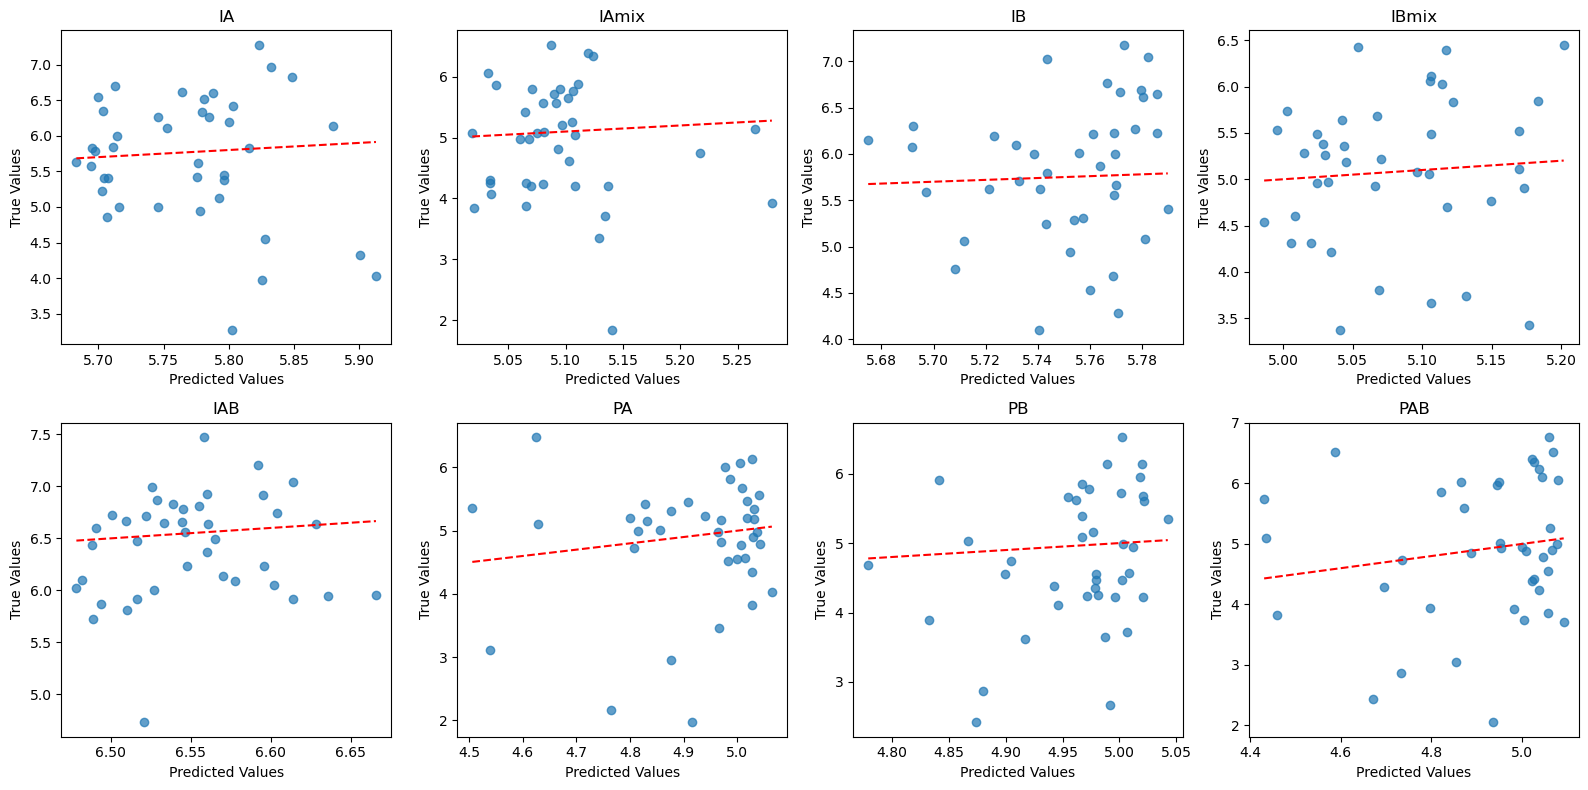

{'IA': '0.506 ± 0.34',
 'IAmix': '0.825 ± 0.37',
 'IB': '0.601 ± 0.18',
 'IBmix': '0.851 ± 0.30',
 'IAB': '0.276 ± 0.03',
 'PA': '0.755 ± 0.59',
 'PB': '0.875 ± 0.23',
 'PAB': '0.907 ± 0.39'}

In [16]:
logits_results = train_model(gin_logits_df)
logits_results

### MPNN

In [19]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio
from openpom.models.mpnn_pom import MPNNPOMModel

ModuleNotFoundError: No module named 'tensorflow'

### Compare results

In [17]:
labels = ["MFP","GIN-LOGITS"]
# labels = ["MFP","GIN-GNN","GIN-LOGITS"]
all_df = pd.DataFrame([mfp_results, logits_results],index=labels)
all_df

,IA,IAmix,IB,IBmix,IAB,PA,PB,PAB
MFP,0.486 ± 0.30,0.808 ± 0.37,0.567 ± 0.15,0.833 ± 0.30,0.281 ± 0.02,0.764 ± 0.65,0.849 ± 0.22,0.930 ± 0.42
GIN-LOGITS,0.506 ± 0.34,0.825 ± 0.37,0.601 ± 0.18,0.851 ± 0.30,0.276 ± 0.03,0.755 ± 0.59,0.875 ± 0.23,0.907 ± 0.39


In [18]:
result_df = all_df.loc[all_df.index != "MFP"].sub(all_df.loc["MFP"], axis=1)
result_df["MEAN"] = result_df.mean(axis=1)
result_df

TypeError: unsupported operand type(s) for -: 'str' and 'str'